In [2]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 8.1 MB/s eta 0:00:00


In [3]:
import random

from deap import algorithms
from deap import tools
from deap import base
from deap import creator
from deap import benchmarks
from deap import cma

import numpy as np

import matplotlib.pyplot as plt

In [4]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness = creator.FitnessMin)

def create_random_rastrigin():
  return random.uniform(-5.12, 5.12)

toolbox.register("attrFloat", create_random_rastrigin)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attrFloat, 2)
toolbox.register("population", tools.initRepeat, list,toolbox.individual)

def evaluate(individual):
  return benchmarks.rastrigin(individual)

toolbox.register("evaluate", evaluate)


In [5]:
def crossover_DE(parent1, parent2, cr):
    assert len(parent1) == len(parent2)
    result = []
    for i in range(len(parent1)):
        if random.random() <= cr:
            result.append(parent1[i])
        else:
            result.append(parent2[i])
    return result


def mutation_DE(individual, direct_vec, F, lower_bound, upper_bound):
    new_individual = np.array(individual) + F * direct_vec
    new_individual = np.clip(new_individual, lower_bound, upper_bound)
    return new_individual


In [6]:
def main():
  generation = 100
  n_population = 200
  F = 0.5
  cr = 0.2

  upper_bound = 5.12
  lower_bound = -5.12

  population = toolbox.population(n = n_population)

  invalid_ind = [ind for ind in population if not ind.fitness.valid]
  fitnesses = map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
      ind.fitness.values = fit

  for idx, ind in enumerate(population):
      if not ind.fitness.valid:
          print(f"Individual {idx} has invalid fitness: {ind.fitness.values}")

  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)

  records = []
  for i in range(generation):
    offspring = []

    # craete donar and crossover process
    for j in range(n_population):
      random_samples = random.sample(population, 3)
      direction_vector = np.array(random_samples[1]) - np.array(random_samples[2])

      donar = mutation_DE(random_samples[0], direction_vector, F, lower_bound, upper_bound)
      new_individual = crossover_DE(population[j], donar, 0.2)

      offspring.append(creator.Individual(new_individual))


    # evaluation of offsprings
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # selection
    next_population = []
    for parent, child in zip(population, offspring):
      if parent.fitness.values < child.fitness.values:
        next_population.append(parent)
      else:
        next_population.append(child)

    for idx, ind in enumerate(next_population):
      if not ind.fitness.valid:
          print(f"[Generation {i}] Individual {idx} has invalid fitness: {ind.fitness.values}")

    records.append(stats.compile(next_population))

    population = next_population

  avgs = [record['avg'] for record in records]
  stds  = [record['std'] for record in records]
  mins  = [record['min'] for record in records]
  maxs  = [record['max'] for record in records]

  plt.plot(avgs, label='avg')
  plt.plot(stds, label='std')
  plt.plot(mins, label='min')
  plt.plot(maxs, label='max')
  plt.legend()
  plt.show()

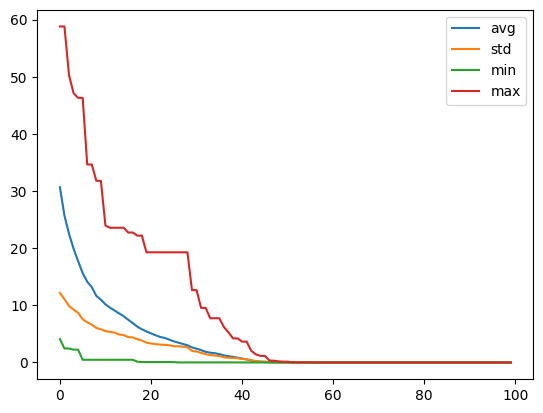

In [7]:
main()